### Edgar Moises Hernandez-Gonzalez
#### 26/05/20
#### Clasificacion de imagenes motoras en EEG con CNN-2D
#### Cargar modelo para evaluacion y predecir
##### Caracteristicas = Espectrogramas STFFT (3D)
##### Concatenacion vertical
##### Resize proporcional de 264x8

In [0]:
from google.colab import drive

In [2]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import (cohen_kappa_score, confusion_matrix,
                             roc_auc_score, roc_curve)
from scipy.signal import spectrogram
import cv2
from keras.utils import to_categorical
from keras.models import load_model

Using TensorFlow backend.


In [0]:
x_train = pd.read_csv("/content/drive/My Drive/BCI-IV-2a/Espectros-STFT-Binaria/MI-EEG-ID-A09T.csv", header=None)
x_test = pd.read_csv("/content/drive/My Drive/BCI-IV-2a/Espectros-STFT-Binaria/MI-EEG-ID-A09E.csv", header=None)
y_test = pd.read_csv("/content/drive/My Drive/BCI-IV-2a/Espectros-STFT-Binaria/Etiquetas-ID-A09E.csv", header=None)

In [3]:
print(x_train.shape)
print(x_test.shape)
print(y_test.shape)

(144, 22000)
(144, 22000)
(144, 1)


In [4]:
# esto se podria calcular asi n_clases = len(np.unique(y)), la y puede ser train o test
n_classes = len(np.unique(y_test))

print("n_classes:", n_classes)

n_classes: 2


In [0]:
# las etiquetas en categorical para poder entrenar data augmentation
y_test_categorical = to_categorical(y_test) # dado que es una sola clase creo no hace falta

In [0]:
#unir 22 canales y resize de tamaño proporcional
def unir_espectrogramas_vertical_resize(data):
  dim = (8, 264) #ancho, alto
  fs = 250
  datos = np.zeros((144,264,8))
  temporal = np.zeros((528,4))
  for i in range(data.shape[0]): #288 muestras
    for j in range(22): #22 canales
      sig = data.iloc[i, j*1000:(j+1)*1000]
      f, t, Sxx = spectrogram(sig, fs) #espectrograma de STFFT
      temporal[j*24:(j+1)*24, :] = Sxx[8:32, :]
    resized = cv2.resize(temporal, dim, interpolation=cv2.INTER_AREA)
    datos[i] = resized
    if i % 100 == 0: #esto solo es para ver como avanza
      print(i)
  return datos

In [7]:
x_train = unir_espectrogramas_vertical_resize(x_train)
x_test = unir_espectrogramas_vertical_resize(x_test)

0
100
0
100


In [8]:
print(x_test.shape)

(144, 264, 8)


In [0]:
x = []
x.append(np.ceil(np.max(x_train)))
# esta linea solo se ocupa si se va a predecir un modelo creado con CV
# x.append(np.ceil(np.max(x_test)))

In [0]:
#convertir a float
x_test = x_test.astype('float32')

#escalar los valores en un rango de 0 a 1 (normalizar)
x_test /= np.ceil(np.max(x))

In [11]:
#convertir de 3D a 4D
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], x_test.shape[2], 1))

print(x_test.shape)

(144, 264, 8, 1)


In [0]:
model = load_model('/content/drive/My Drive/BCI-IV-2a/Modelos/Modelo_ID_STFTDA09.hdf5')

In [13]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 264, 8, 16)        160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 132, 4, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 132, 4, 16)        2320      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 66, 2, 16)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2112)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               270464    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)              

In [0]:
test_loss, test_acc = model.evaluate(x_test, y_test_categorical, verbose=0)

In [15]:
print("loss: %.4f" % test_loss)
print("accuracy: %.4f" % test_acc)

loss: 0.3826
accuracy: 0.8264


In [0]:
probabilidades = model.predict(x_test)
y_pred = np.argmax(probabilidades, 1) #1=fila

In [17]:
kappa = cohen_kappa_score(y_test, y_pred)
print("kappa: %.4f" % kappa)

kappa: 0.6528


In [18]:
matriz_confusion = confusion_matrix(y_test, y_pred)
print("confusion matrix:\n", matriz_confusion)  

confusion matrix:
 [[57 15]
 [10 62]]


AUC: 0.9194


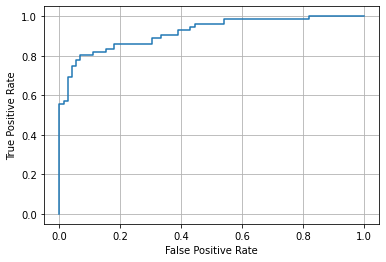

In [19]:
probabilidades = probabilidades[:, 1]
auc = roc_auc_score(y_test, probabilidades)
fpr, tpr, thresholds = roc_curve(y_test, probabilidades)

print("AUC: %.4f" % auc)
plt.plot(fpr, tpr)
plt.grid()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()